Converting annotations to object segmentation mask images

- https://towardsdatascience.com/generating-image-segmentation-masks-the-easy-way-dd4d3656dbd1
- https://copycoding.tistory.com/150

In [34]:
import os
import pandas as pd
import cv2
import json
import numpy as np 
import matplotlib.pyplot as plt
import ast
from PIL import Image

In [4]:
path_tetrapod = '/home/mvlab/Downloads/dataset/통영 segment/'
os.path.isdir(path_tetrapod)

True

In [5]:
path_label = path_tetrapod + 'segmentation_csv.csv'

os.path.isfile(path_label)

True

In [6]:
df = pd.read_csv(path_label)
df.shape

(149, 7)

In [7]:
df.filename.nunique(), df.filename.unique()

(7,
 array(['Sacheon_1.png', 'Tongyeong_seg_1.png', 'Tongyeong_seg_2.png',
        'Tongyeong_seg_3.png', 'Tongyeong_seg_4.jpg',
        'Tongyeong_seg_5.jpg', 'Tongyeong_seg_6.png'], dtype=object))

In [8]:
df

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,Sacheon_1.png,2749699,{},5,0,"{""name"":""polygon"",""all_points_x"":[224,248,240,...","{""class"":""Person""}"
1,Sacheon_1.png,2749699,{},5,1,"{""name"":""polygon"",""all_points_x"":[1917,1493,12...","{""class"":""Water""}"
2,Sacheon_1.png,2749699,{},5,2,"{""name"":""polygon"",""all_points_x"":[2,196,222,23...","{""class"":""Water""}"
3,Sacheon_1.png,2749699,{},5,3,"{""name"":""polygon"",""all_points_x"":[614,570,565,...","{""class"":""Background""}"
4,Sacheon_1.png,2749699,{},5,4,"{""name"":""polygon"",""all_points_x"":[495,497,544,...","{""class"":""Construction""}"
...,...,...,...,...,...,...,...
144,Tongyeong_seg_6.png,3317789,{},43,38,"{""name"":""polygon"",""all_points_x"":[1916,1606,16...","{""class"":""Obstacle""}"
145,Tongyeong_seg_6.png,3317789,{},43,39,"{""name"":""polygon"",""all_points_x"":[1384,1461,15...","{""class"":""Obstacle""}"
146,Tongyeong_seg_6.png,3317789,{},43,40,"{""name"":""polygon"",""all_points_x"":[1919,1894,18...","{""class"":""Obstacle""}"
147,Tongyeong_seg_6.png,3317789,{},43,41,"{""name"":""polygon"",""all_points_x"":[1568,1561,15...","{""class"":""Obstacle""}"


In [56]:
points_sum = 0
for region_shape_attributes in df.region_shape_attributes:
    polygons_dict = ast.literal_eval(region_shape_attributes)
    points_x = polygons_dict['all_points_x']
    points_y = polygons_dict['all_points_y']
    points_sum += len(points_x)
    #print(points_sum, len(points_x), len(points_y))
print(points_sum)

3157


In [194]:
detect_class = ['bg', 'person', 'fishing', 'ship']
segment_class = ['bg', 'land', 'tetrapod', 'water']

In [195]:
class_aeroscapes = ['bg', 'person', 'bike', 'car', 'drone', 'boat', 'animal', 'obstacle', 'construction', 'vegetation', 'road', 'sky']
class_aeroscapes += ['water']
seg_k = len(class_aeroscapes)

In [ ]:
segment_class = class_aeroscapes

In [239]:
def parse_dataframe(df_t):
    annotation = dict()

    for i in range(len(df_t)):
        row = df_t.iloc[i]

        filename = row.filename
        region_shape_attributes = row.region_shape_attributes
        region_attributes = row.region_attributes
        points = ast.literal_eval(region_shape_attributes)
        cls = ast.literal_eval(region_attributes)
        #print(i, type(region_shape_attributes), type(points), points.keys())
        all_points_x = points['all_points_x']
        all_points_y = points['all_points_y']
        try:
            cls = cls['class']
        except:
            print('no cls')
            continue

        all_points_xy = np.stack((all_points_x, all_points_y), 1)

        print(i, filename, cls, all_points_xy.shape)
        if filename not in annotation.keys():        
            annotation[filename] = []

        annotation[filename].append([all_points_xy, cls])

    print(len(annotation), annotation.keys())
    return annotation

In [236]:
def convert_point_to_mask(annotation):

    mask = np.zeros((1080, 1920), np.uint8)
    k_points = 0
    for key in annotation.keys():
        values = annotation[key]
        print(key, type(values), len(values))
        for value in values:
            points = value[0]
            cls = value[1]
            if cls == 'Background':            
                cls = 'bg'
            #print('cls', type(cls), cls)
            cls_num = segment_class.index(cls.lower())
            print(type(value), len(value), 'points', points.shape, cls, cls_num)        

            #points = np.array([sample_points]).reshape([-1, 2]).astype(np.int32)
            color = (cls_num * 1)
            #(np.random.randint(0, 255))
            cv2.fillPoly(mask, [points], color=color)        
            k_points += len(points)

    print('k_points', k_points, 'unique', np.unique(mask))
    return mask

Tongyeong_seg_5.jpg


Sacheon_1.png
0 Sacheon_1.png Person (10, 2)
1 Sacheon_1.png Water (107, 2)
2 Sacheon_1.png Water (14, 2)
3 Sacheon_1.png Background (114, 2)
4 Sacheon_1.png Construction (8, 2)
1 dict_keys(['Sacheon_1.png'])
Sacheon_1.png <class 'list'> 5
<class 'list'> 2 points (10, 2) Person 1
<class 'list'> 2 points (107, 2) Water 12
<class 'list'> 2 points (14, 2) Water 12
<class 'list'> 2 points (114, 2) bg 0
<class 'list'> 2 points (8, 2) Construction 8
k_points 253 unique [ 0  1  8 12]
Tongyeong_seg_1.png
0 Tongyeong_seg_1.png Person (8, 2)
1 Tongyeong_seg_1.png Person (7, 2)
2 Tongyeong_seg_1.png Water (40, 2)
3 Tongyeong_seg_1.png Car (22, 2)
4 Tongyeong_seg_1.png Car (22, 2)
5 Tongyeong_seg_1.png Car (6, 2)
6 Tongyeong_seg_1.png Car (12, 2)
7 Tongyeong_seg_1.png Car (10, 2)
8 Tongyeong_seg_1.png Car (5, 2)
9 Tongyeong_seg_1.png Car (10, 2)
10 Tongyeong_seg_1.png Car (13, 2)
11 Tongyeong_seg_1.png Background (28, 2)
12 Tongyeong_seg_1.png Road (19, 2)
13 Tongyeong_seg_1.png Road (43, 2)
14 To

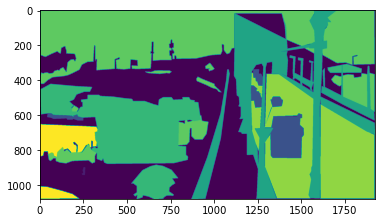

In [242]:
for file_target in df.filename.unique():
    print()
    print(file_target)

    df_t = df[df.filename==file_target]
    annotation = parse_dataframe(df_t)
    mask = convert_point_to_mask(annotation)
    plt.imshow(mask)
    Image.fromarray(mask).save(file_target[:-3] + 'png')
    Image.fromarray(mask*50).save(file_target[:-4] + '_show.png')

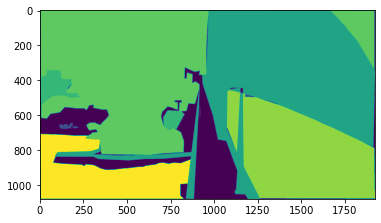